<a href="https://colab.research.google.com/github/kejohns19/Udacity_DRLN/blob/master/Pong_REINFORCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install package for displaying animation
!pip install JSAnimation

# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

  Created wheel for JSAnimation: filename=JSAnimation-0.1-cp36-none-any.whl size=11428 sha256=d59f723068da6380d16614342d2e8143e0d97b7e783a971b5fb41a5544c0ffee
  Stored in directory: /root/.cache/pip/wheels/3c/c2/b2/b444dffc3eed9c78139288d301c4009a42c0dd061d3b62cead
Successfully built JSAnimation
using device:  cuda:0


In [2]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


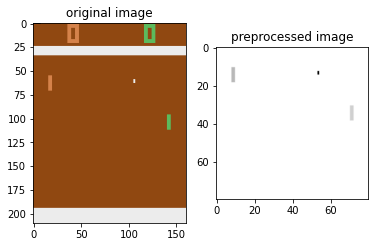

In [3]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(50):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F



# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
        
        # 80x80 to outputsize x outputsize
        # outputsize = (inputsize - kernel_size + stride)/stride 
        # (round up if not an integer)

        # output = 20x20 here
        self.conv1 = nn.Conv2d(2, 16, kernel_size=4, stride=4)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)
        self.size=32*9*9
        
        # 1 fully connected layer
        self.fc1 = nn.Linear(self.size, 128)
        self.fc2 = nn.Linear(128,1)
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
    
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # flatten the tensor
        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        return self.sig(self.fc2(x))

# use your own policy!
policy=Policy().to(device)


#policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=2e-4)

In [6]:
envs = pong_utils.parallelEnv('PongDeterministic-v4', n=4, seed=12345)
prob, state, action, reward = pong_utils.collect_trajectories(envs, policy, tmax=100)

In [8]:
print(reward)

[array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([-1.,  0., -1., -1.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0.]), array([0., 0., 0., 0

In [9]:
import numpy as np

def surrogate(policy, old_probs, states, actions, rewards,
              discount = 0.995, beta=0.01):

    ########
    ## 
    ## WRITE YOUR OWN CODE HERE
    ##
    ########
    
    discount = discount**np.arange(len(rewards))
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
    
    # convert rewards to future rewards
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
  
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10
    
    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    
    # convert everything into pytorch tensors and move to gpu if available
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)
    
    # convert states to policy (or probability)
    new_probs = pong_utils.states_to_prob(policy, states)
    new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0-new_probs)
    
    ratio = new_probs/old_probs

    # include a regularization term
    # this steers new_policy towards 0.5
    # which prevents policy to become exactly 0 or 1
    # this helps with exploration
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    return torch.mean(ratio*rewards + beta*entropy)


Lsur= surrogate(policy, prob, state, action, reward)

print(Lsur)

tensor(0.0069, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
optimizer = optim.Adam(policy.parameters(), lr=1e-3)
from parallelEnv import parallelEnv
import numpy as np
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 2000
# episode = 800

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

# initialize environment
envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
beta = .05
tmax = 100

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)

    # this is the SOLUTION!
    # use your own surrogate function
    L = -surrogate(policy, old_probs, states, actions, rewards, beta=beta)
    
    #L = -pong_utils.surrogate(policy, old_probs, states, actions, rewards, beta=beta)
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    del L
        
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.998
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}, tmax: {2:d}".format(e+1,np.mean(total_rewards), tmax))
        print(total_rewards)
        
        # increase tmax
        if mean_rewards[-1] > -3:
            tmax += 10
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()
    

Episode: 20, score: -3.625000, tmax: 100
[-4. -2. -4. -2. -2. -5. -5. -5.]


Episode: 40, score: -3.625000, tmax: 100
[-5. -1. -3. -5. -1. -4. -5. -5.]
